In [6]:
import cloudknot as ck

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [36]:
ck.set_region('us-east-1')

In [3]:
def afq_prek_api(subject):
    import fury
    import xvfbwrapper # do this until we can do optional installs
    
    import logging
    import s3fs
    import numpy as np
    import os.path as op
    import os

    import AFQ.api as api
    import AFQ.data as afd
    
    use_matlab=False
    use_post_sess=False
    
    logging.basicConfig(level=logging.INFO)
    log = logging.getLogger(__name__)  

    fs = s3fs.S3FileSystem()

    bids_folder = op.join(op.expanduser('~'), 'prek-diffusion')
    dmriprep_folder = op.join(bids_folder, 'derivatives/dmriprep')
    
    dwi_dir = f'prek-diffusion/derivatives/sub-{subject}'
    dwi_dir_local = op.join(dmriprep_folder, f'sub-{subject}')
    os.makedirs(op.join(dwi_dir_local, "dtiInit_ses-pre/dwi"), exist_ok=True)
    os.makedirs(op.join(dwi_dir_local, "dtiInit_ses-post/dwi"), exist_ok=True)
    
    #fs.get(f"prek-diffusion/derivatives/afq/sub{subject}", op.join(op.expanduser('~'), "prek-diffusion/afq/"), recursive=True)

    # use matlab tractography
    if use_matlab:
        fs.get(f"prek-diffusion/mat2py/tract_test_sub-{subject}.trk",
           op.join(
               bids_folder,
               f"afq/sub-{subject}/dtiInit_ses-pre/"
               "sub-1110_ses-pre_acq-b1500_dwi_aligned_trilin_space-RASMM_model-DTI_desc-det_tractography.trk"))
    
    # pre sess
    prek_fdata_src = op.join(dwi_dir, f"dtiInit_ses-pre/sub-{subject}_ses-pre_acq-b1500_dwi_aligned_trilin.nii.gz")
    prek_fbval_src = op.join(dwi_dir, f"dtiInit_ses-pre/sub-{subject}_ses-pre_acq-b1500_dwi_aligned_trilin.bvals")
    prek_fbvec_src = op.join(dwi_dir, f"dtiInit_ses-pre/sub-{subject}_ses-pre_acq-b1500_dwi_aligned_trilin.bvecs")
    
    prek_fdata = op.join(dwi_dir_local, f"dtiInit_ses-pre/dwi/sub-{subject}_ses-pre_acq-b1500_aligned_trilin_dwi.nii.gz")
    prek_fbval = op.join(dwi_dir_local, f"dtiInit_ses-pre/dwi/sub-{subject}_ses-pre_acq-b1500_aligned_trilin_dwi.bvals")
    prek_fbvec = op.join(dwi_dir_local, f"dtiInit_ses-pre/dwi/sub-{subject}_ses-pre_acq-b1500_aligned_trilin_dwi.bvecs")
    
    fs.get(prek_fdata_src, prek_fdata)
    fs.get(prek_fbval_src, prek_fbval)  
    fs.get(prek_fbvec_src, prek_fbvec)
    fs.get(
        f'prek-diffusion/derivatives/sub-{subject}/freesurfer/mri/aparc+aseg.nii.gz',
        op.join(dwi_dir_local, 'dtiInit_ses-pre/aparc+aseg_seg.nii.gz'),
    )

    # post sess
    if use_post_sess:
        prek_fdata_src = op.join(dwi_dir, f"dtiInit_ses-post/sub-{subject}_ses-post_acq-b1500_dwi_aligned_trilin.nii.gz")
        prek_fbval_src = op.join(dwi_dir, f"dtiInit_ses-post/sub-{subject}_ses-post_acq-b1500_dwi_aligned_trilin.bvals")
        prek_fbvec_src = op.join(dwi_dir, f"dtiInit_ses-post/sub-{subject}_ses-post_acq-b1500_dwi_aligned_trilin.bvecs")

        prek_fdata = op.join(dwi_dir_local, f"dtiInit_ses-post/dwi/sub-{subject}_ses-post_acq-b1500_aligned_trilin_dwi.nii.gz")
        prek_fbval = op.join(dwi_dir_local, f"dtiInit_ses-post/dwi/sub-{subject}_ses-post_acq-b1500_aligned_trilin_dwi.bvals")
        prek_fbvec = op.join(dwi_dir_local, f"dtiInit_ses-post/dwi/sub-{subject}_ses-post_acq-b1500_aligned_trilin_dwi.bvecs")

        fs.get(prek_fdata_src, prek_fdata)
        fs.get(prek_fbval_src, prek_fbval)  
        fs.get(prek_fbvec_src, prek_fbvec)
        fs.get(
            f'prek-diffusion/derivatives/sub-{subject}/freesurfer/mri/aparc+aseg.nii.gz',
            op.join(dwi_dir_local, 'dtiInit_ses-post/aparc+aseg_seg.nii.gz'),
        )
    
    afd.to_bids_description(bids_folder, Name="prek", Subjects=[subject])
    afd.to_bids_description(dmriprep_folder, Name="prek", PipelineDescription={"Name":"dmriprep"})

    b0_threshold = 50
    
    # todo: set subject as seed for reproducibility (needs to wait for PR)
    tracking_params = {"n_seeds": 160000, "random_seeds": True, "directions": 'det', 'rng_seed': int(subject),
                       "seed_mask": "dti_fa", "seed_threshold": 0.3,
                       "stop_mask": "dti_fa", "stop_threshold": 0.2}
    segmentation_params = {"prob_threshold": 0, "b0_threshold": b0_threshold, "filter_by_endpoints": False, "clip_edges": True}
    clean_params = {"clean_rounds": 1}

    myafq = api.AFQ(bids_folder,
                    virtual_frame_buffer=True, # TURN ON ON CLOUD
                    b0_threshold=b0_threshold,
                    
                    reg_template="mni_T1",
                    reg_subject="power_map",

                    tracking_params=tracking_params,
                    segmentation_params=segmentation_params,
                    clean_params=clean_params)
    #myafq.get_streamlines()
    myafq.export_registered_b0()
    myafq.get_template_xform()
    myafq.export_bundles()
    myafq.get_tract_profiles()
    myafq.viz_bundles(export_as_gif=True)
    myafq.viz_ROIs(export_as_gif=True)
    if use_matlab:
        fs.put(op.join(bids_folder, "afq"), "prek-diffusion/derivatives_mat/afq", recursive=True)
    else:
        fs.put(op.join(bids_folder, "afq"), "prek-diffusion/derivatives_power/afq", recursive=True)

In [4]:
afq_prek_api(1241)

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /home/john/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /home/john/AFQ_data/callosum_templates 
/home/john/miniconda3/envs/afq/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)
INFO:AFQ.Segmentation:Preparing Segmentation Parameters
INFO:AFQ.Segmentation:Preprocessing Streamlines
INFO:AFQ.Segmentation:Assigning Streamlines to Bundles
INFO:AFQ.Segmentation:Finding Streamlines for ATR_R
INFO:AFQ.Segmentation:72191 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:1566 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for ATR_L


INFO:AFQ.Segmentation:75220 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:1278 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for CGC_R


INFO:AFQ.Segmentation:33843 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:129 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for CGC_L


INFO:AFQ.Segmentation:24549 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:452 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for CST_R


INFO:AFQ.Segmentation:41482 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:1655 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for CST_L


INFO:AFQ.Segmentation:48282 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:1925 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for IFO_R


INFO:AFQ.Segmentation:42274 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:1261 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for IFO_L


INFO:AFQ.Segmentation:48604 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:518 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for ILF_R


INFO:AFQ.Segmentation:27851 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:877 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for ILF_L


INFO:AFQ.Segmentation:34661 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:511 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for SLF_R


INFO:AFQ.Segmentation:50109 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:3847 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for SLF_L


INFO:AFQ.Segmentation:62638 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:1937 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for ARC_R


INFO:AFQ.Segmentation:36530 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:402 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for ARC_L


INFO:AFQ.Segmentation:51521 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:2313 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for UNC_R


INFO:AFQ.Segmentation:17447 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:1798 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for UNC_L


INFO:AFQ.Segmentation:31497 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:2017 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for FA


INFO:AFQ.Segmentation:39009 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:4033 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Finding Streamlines for FP


INFO:AFQ.Segmentation:26285 streamlines exceed the probability threshold.


INFO:AFQ.Segmentation:689 streamlines selected with waypoint ROIs
INFO:AFQ.Segmentation:Re-orienting streamlines to consistent directions
INFO:AFQ.Segmentation:Processing ATR_R
INFO:AFQ.Segmentation:Processing ATR_L
INFO:AFQ.Segmentation:Processing CGC_R
INFO:AFQ.Segmentation:Processing CGC_L
INFO:AFQ.Segmentation:Processing CST_R
INFO:AFQ.Segmentation:Processing CST_L
INFO:AFQ.Segmentation:Processing IFO_R
INFO:AFQ.Segmentation:Processing IFO_L
INFO:AFQ.Segmentation:Processing ILF_R
INFO:AFQ.Segmentation:Processing ILF_L
INFO:AFQ.Segmentation:Processing SLF_R
INFO:AFQ.Segmentation:Processing SLF_L
INFO:AFQ.Segmentation:Processing ARC_R
INFO:AFQ.Segmentation:Processing ARC_L
INFO:AFQ.Segmentation:Processing UNC_R
INFO:AFQ.Segmentation:Processing UNC_L


INFO:AFQ.Segmentation:Processing FA
INFO:AFQ.Segmentation:Processing FP
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_space-RASMM_model-DTI_desc-det-AFQ_tractography.trk
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_space-RASMM_model-DTI_desc-det-AFQ-clean_tractography.trk
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/clean_bundles/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_space-RASMM_model-DTI_desc-det-AFQ-ATR_R_tractography.trk
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/clean_bundles/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_space-RASMM_model-DTI_desc-det-AFQ-ATR_L_tractography.trk
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/clean_bundles/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_space-RASMM_model-DTI_desc-det-AFQ-CGC_R_tractography.trk
INFO:AFQ.api:Saving /home/john/prek-d

INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/clean_bundles/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_space-RASMM_model-DTI_desc-det-AFQ-SLF_R_tractography.trk
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/clean_bundles/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_space-RASMM_model-DTI_desc-det-AFQ-SLF_L_tractography.trk
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/clean_bundles/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_space-RASMM_model-DTI_desc-det-AFQ-ARC_R_tractography.trk
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/clean_bundles/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_space-RASMM_model-DTI_desc-det-AFQ-ARC_L_tractography.trk
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/clean_bundles/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_space-RASMM_model-DTI_desc-det-AFQ-UNC_R_tractography.trk
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/clean_bu

INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/ROIs/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_desc-ROI-SLF_R-3-exclude.nii.gz
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/ROIs/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_desc-ROI-SLF_L-1-include.nii.gz
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/ROIs/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_desc-ROI-SLF_L-2-include.nii.gz
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/ROIs/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_desc-ROI-SLF_L-3-exclude.nii.gz
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/ROIs/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_desc-ROI-ARC_R-1-include.nii.gz
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/ROIs/sub-1241_ses-pre_acq-b1500_aligned_trilin_dwi_desc-ROI-ARC_R-2-include.nii.gz
INFO:AFQ.api:Saving /home/john/prek-diffusion/afq/sub-1241/ses-pre/ROIs/sub-1241_ses-pre_acq-b1500_a

ClientError: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied

In [11]:
afq_knot = ck.Knot(name='afq_prek-64gb-20809-1',
                  func=afq_prek_api,
                  base_image='libglxvfb:1',
                  image_github_installs="https://github.com/36000/pyAFQ.git@wm_mask-dict",
                  pars_policies=('AmazonS3FullAccess',),
#                   resource_type="SPOT",
#                   bid_percentage=100,
                  memory=64000)

In [12]:
inputs = [
    1110,
    1112,
    1113,
    1103,
    1184,
    1208,
    1210,
    1241,
    1262,
    1271]
#inputs = [1112, 1110, 1241]

In [13]:
ft = afq_knot.map(inputs)

In [37]:
afq_knot.view_jobs()

Job ID              Name                        Status   
---------------------------------------------------------
d74e8646-f8d4-4997-879f-42bb855eb3f3        afq-prek-64gb-20809-1-0        SUCCEEDED


In [38]:
j0 = afq_knot.jobs[0]

In [39]:
j0.status

{'status': 'SUCCEEDED',
 'statusReason': None,
 'attempts': [],
 'arrayProperties': {'statusSummary': {'STARTING': 0,
   'FAILED': 0,
   'RUNNING': 0,
   'SUCCEEDED': 10,
   'RUNNABLE': 0,
   'SUBMITTED': 0,
   'PENDING': 0},
  'size': 10}}

In [40]:
afq_knot.clobber()

In [22]:
import s3fs
import os
s3 = s3fs.S3FileSystem(anon=False)

In [7]:
try:
    s3.get(f'prek-diffusion/derivatives/AFQ_allvols_rt_ses-pre_19-Nov-2019.mat', 'pre_source.mat')
    s3.get(f'prek-diffusion/derivatives/AFQ_allvols_rt_ses-post_20-Nov-2019.mat', 'post_source.mat')
except FileNotFoundError:
    print(f'mAFQ streamlines not found')
    
# use AFQ browser to process this

In [23]:
os.makedirs('pre', exist_ok=True)
os.makedirs('post', exist_ok=True)
for subject in inputs:
    try:
        s3.get(f'prek-diffusion/derivatives_power/afq/sub-{subject}/ses-pre/sub-{subject}_ses-pre_acq-b1500_aligned_trilin_dwi_profiles.csv', f'pre/sub-{subject}_pyAFQ_profiles.csv')
        s3.get(f'prek-diffusion/derivatives_power/afq/sub-{subject}/ses-post/sub-{subject}_ses-post_acq-b1500_aligned_trilin_dwi_profiles.csv', f'post/sub-{subject}_pyAFQ_profiles.csv')
    except FileNotFoundError:
        print(f'subject {subject} streamlines not found')

In [31]:
from pathlib import Path
import pandas as pd
def combine_profiles_in_folder(tract_profile_folder, outfile):
    """
    Combine tract profiles from different subjects / sessions
    into one CSV.

    Parameters
    ----------
    tract_profile_folder : path to folder
        Folder with all tract profiles you wish to merge.
        Will also search subdirectories recursively.
        It will select all files of the form '*profiles.csv'.
    outfile : filename
        Filename for the output CSV.

    Returns
    -------
    Ouput CSV's pandas dataframe.
    """
    dfs = []
    for path in Path(tract_profile_folder).rglob('*profiles.csv'):
        profiles = pd.read_csv(path)

        subject_name = path.name.split('sub-')[1].split('_')[0]
        if 'ses-' in path.name:
            session_name = path.name.split('ses-')[1].split('_')[0]
        else:
            session_name = 'unknown'

        profiles['subjectID'] = subject_name
        profiles['sessionID'] = session_name
        dfs.append(profiles)

    df = pd.concat(dfs)
    df.to_csv(outfile, index=False)
    return df

In [49]:
import AFQ.viz.utils as vut
from importlib import reload
reload(vut)
combine_profiles_in_folder('./pre', 'pyAFQ_pre_profiles_combined.csv')
combine_profiles_in_folder('./post', 'pyAFQ_post_profiles_combined.csv')
comparisons = vut.LongitudinalCSVComparison('prek-CSVs',
                            ['./pyAFQ_pre_profiles_combined.csv', './pyAFQ_post_profiles_combined.csv', './AFQ-browser_post/AFQ-browser/client/data/nodes.csv', './AFQ-browser/client/data/nodes.csv'],
                            ['pyAFQ-pre', 'pyAFQ-post', 'mAFQ-post', 'mAFQ-pre'], is_mats=[False, False, True, True])

In [50]:
#comparisons.tract_profiles(out_file_name='./mvpy_comparison')
#print(comparisons.contrast_index(out_file_name='./mvpy_contrast'))


In [51]:
# pd = compare_profiles_from_csv(['./pyAFQ_profiles_combined.csv', './AFQ-browser/client/data/nodes.csv'],
#                           ['pyAFQ', 'mAFQ'], is_mats=[False, True], file_name='./mvpy_comparison',
#                           scalar='dti_md', mat_scalar='md', mat_scale=0.001, max_scalar=0.002)
# print(pd)
# comparisons.tract_profiles(out_file_name='./mvpy_comparison')
# print(comparisons.contrast_index(out_file_name='./mvpy_contrast'))

/home/john/pyAFQ/AFQ/viz/utils.py:886: RuntimeWarning: Mean of empty slice
  all_sub_means[m, k] = np.nanmean(bundle_profiles, axis=2)
INFO:AFQ.csv:3% NaNs found in scalar dti_md for subject 1112 for bundle ATR_L for CSV pyAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_md for subject 1210 for bundle ATR_L for CSV pyAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_md for subject 1241 for bundle ATR_R for CSV pyAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_md for subject 1210 for bundle ATR_R for CSV pyAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_md for subject 1208 for bundle ATR_R for CSV pyAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_md for subject 1184 for bundle CST_L for CSV pyAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_md for subject 1241 for bundle CST_L for CSV pyAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_md 

INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1262 for bundle CST_L for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1113 for bundle CST_L for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1184 for bundle CST_L for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1241 for bundle CST_L for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1208 for bundle CST_L for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1271 for bundle CST_L for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1110 for bundle CST_L for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1112 for bundle CST_L for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1210 for 

INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1113 for bundle FP for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1184 for bundle FP for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1241 for bundle FP for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1103 for bundle FP for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1208 for bundle FP for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1271 for bundle FP for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1110 for bundle FP for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1112 for bundle FP for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1210 for bundle FP for CSV mAFQ-pre. NaN

INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1112 for bundle IFO_R for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1210 for bundle IFO_R for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1262 for bundle IFO_R for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1113 for bundle ILF_L for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1184 for bundle ILF_L for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1241 for bundle ILF_L for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1103 for bundle ILF_L for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1208 for bundle ILF_L for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1271 for bund

INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1210 for bundle SLF_R for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1262 for bundle SLF_R for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1113 for bundle SLF_R for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1184 for bundle SLF_R for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1241 for bundle SLF_R for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:4% NaNs found in scalar dti_fa for subject 1103 for bundle SLF_R for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1208 for bundle SLF_R for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1271 for bundle SLF_R for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:1% NaNs found in scalar dti_fa for subject 1110 for b

INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1262 for bundle UNC_L for CSV mAFQ-post. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1113 for bundle UNC_R for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1184 for bundle UNC_R for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1241 for bundle UNC_R for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1103 for bundle UNC_R for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1208 for bundle UNC_R for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1271 for bundle UNC_R for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1110 for bundle UNC_R for CSV mAFQ-pre. NaNs interpolated. 
INFO:AFQ.csv:2% NaNs found in scalar dti_fa for subject 1112 for bundle

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc39b766b50>,
       dtype=object))

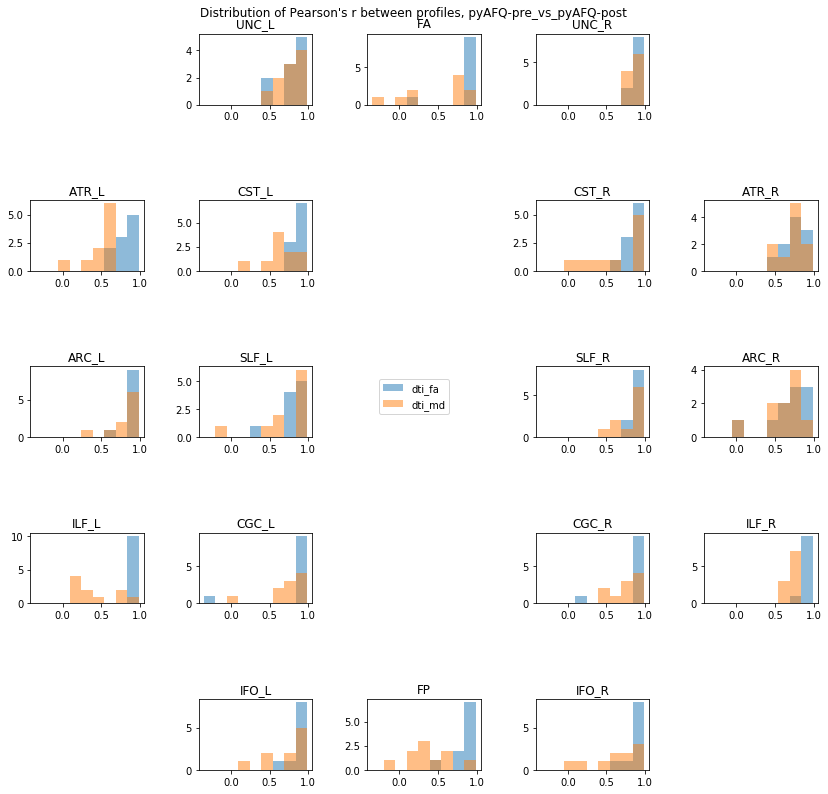

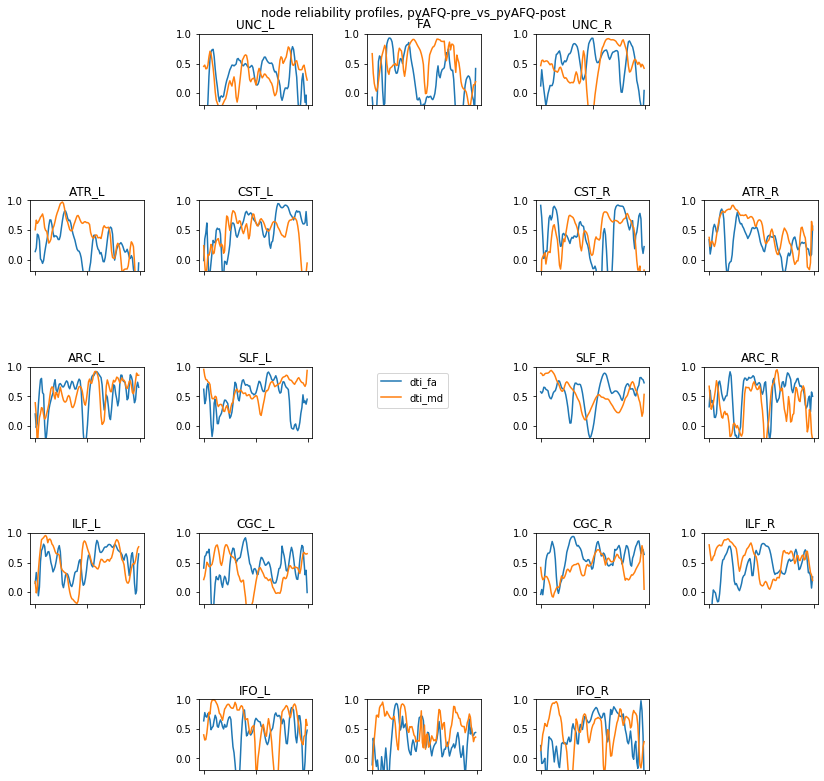

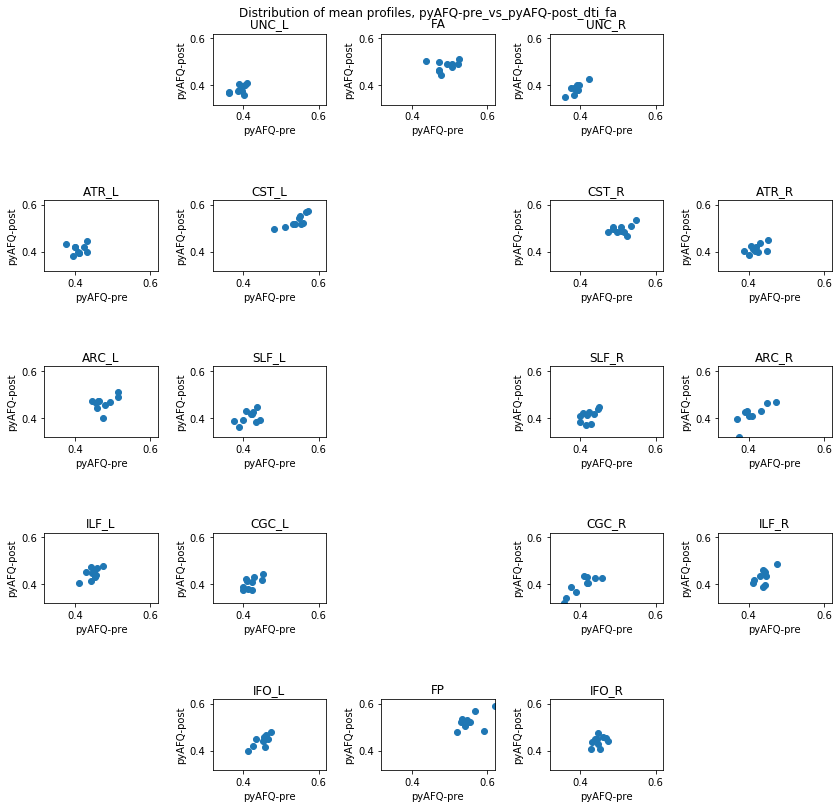

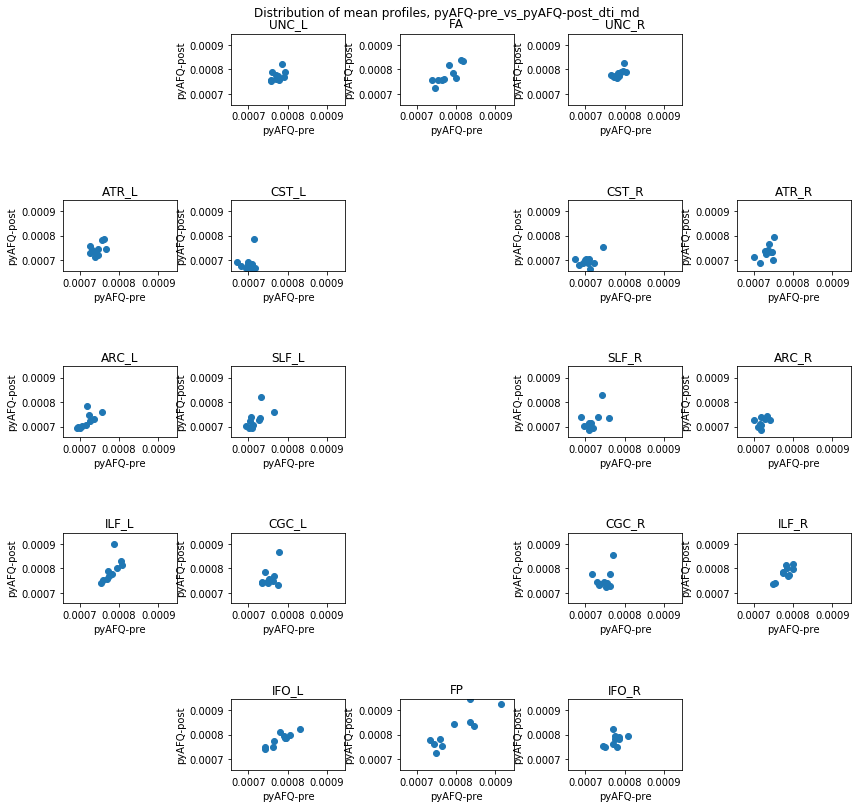

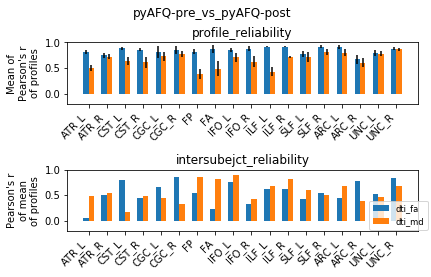

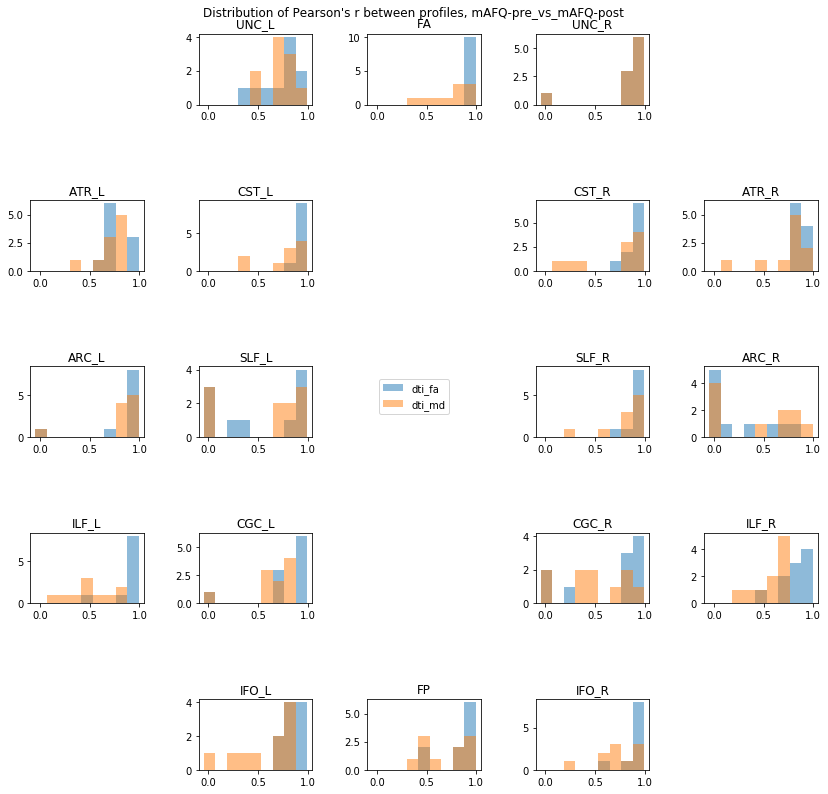

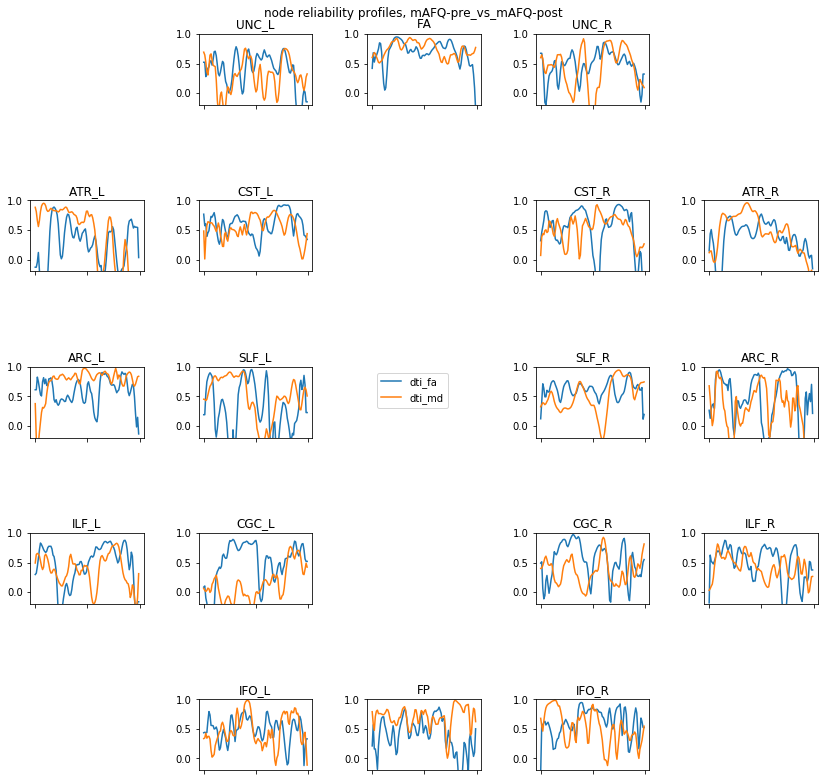

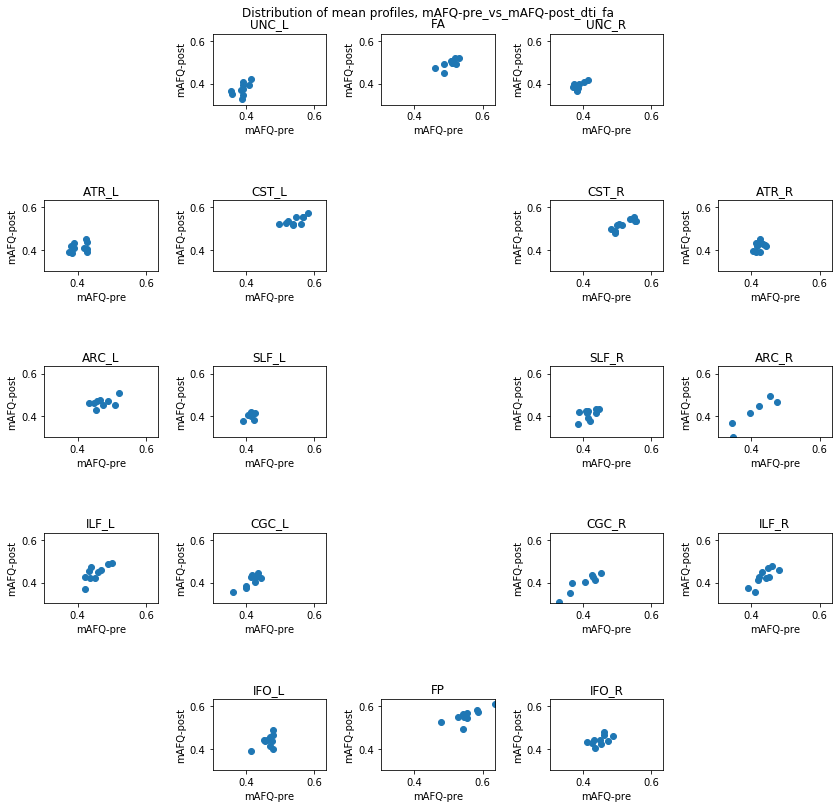

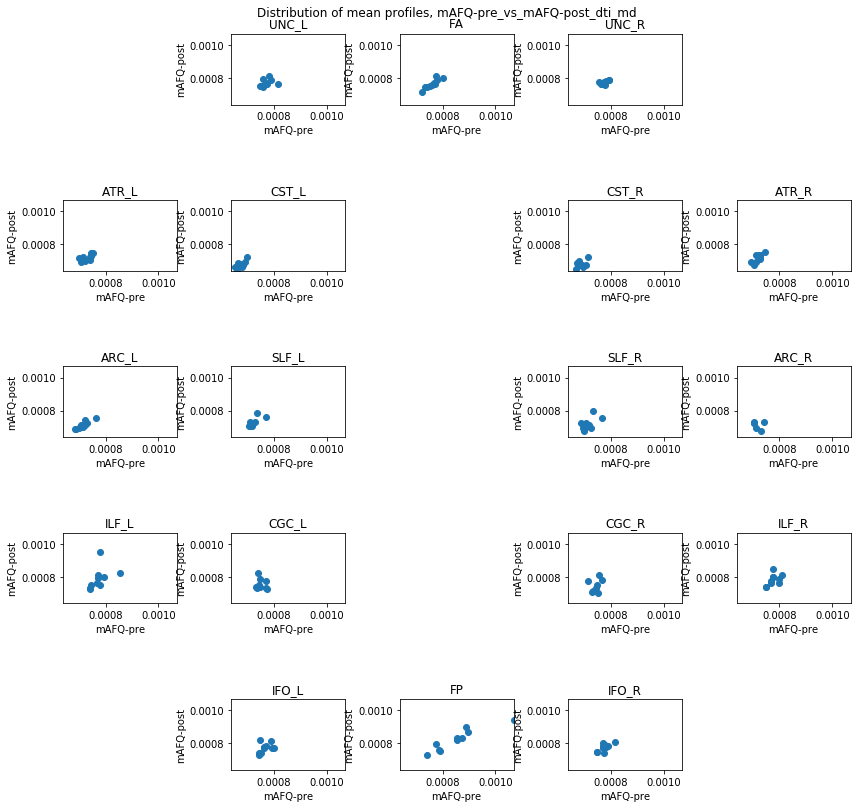

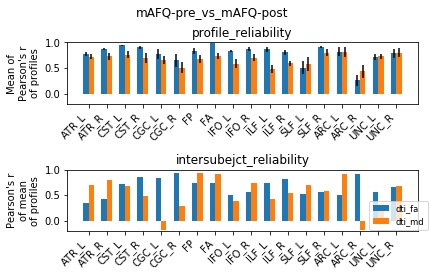

In [52]:
comparisons.reliability_plots(names=['pyAFQ-pre', 'pyAFQ-post'], ylims=[-0.2, 1.0], show_plots=True)
comparisons.reliability_plots(names=['mAFQ-pre', 'mAFQ-post'],  ylims=[-0.2, 1.0],show_plots=True)

In [ ]:
# comparisons.tract_profiles(names=['pyAFQ-pre', 'pyAFQ-post'])
# comparisons.tract_profiles(names=['mAFQ-pre', 'mAFQ-post'])

INFO:AFQ.csv:NaNs found in scalar dti_fa for subject 1113 for bundle CST_L for CSV mAFQ-pre. These Nans were replaced with 0.
INFO:AFQ.csv:NaNs found in scalar dti_fa for subject 1113 for bundle CST_R for CSV mAFQ-pre. These Nans were replaced with 0.
/home/john/pyAFQ/AFQ/viz/utils.py:778: RuntimeWarning: invalid value encountered in true_divide
  / (profile + other_profile)
INFO:AFQ.csv:NaNs found in scalar dti_fa for subject 1184 for bundle ATR_L for CSV mAFQ-pre. These Nans were replaced with 0.
INFO:AFQ.csv:NaNs found in scalar dti_fa for subject 1184 for bundle ATR_R for CSV mAFQ-pre. These Nans were replaced with 0.
/home/john/pyAFQ/AFQ/viz/utils.py:778: RuntimeWarning: invalid value encountered in true_divide
  / (profile + other_profile)
INFO:AFQ.csv:NaNs found in scalar dti_fa for subject 1184 for bundle CST_L for CSV mAFQ-pre. These Nans were replaced with 0.
INFO:AFQ.csv:NaNs found in scalar dti_fa for subject 1184 for bundle CST_R for CSV mAFQ-pre. These Nans were replaced 

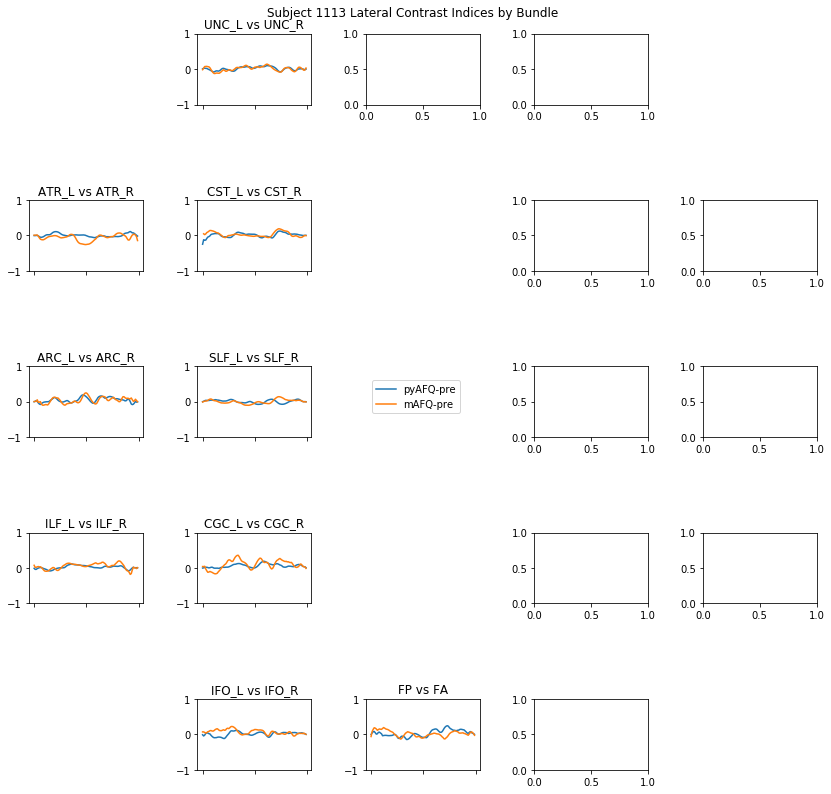

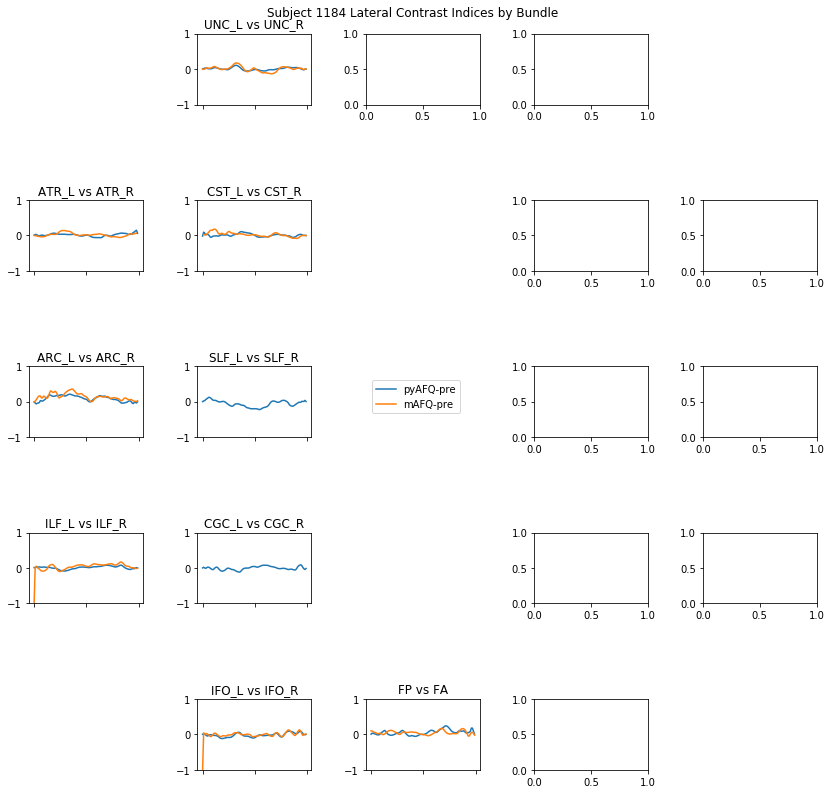

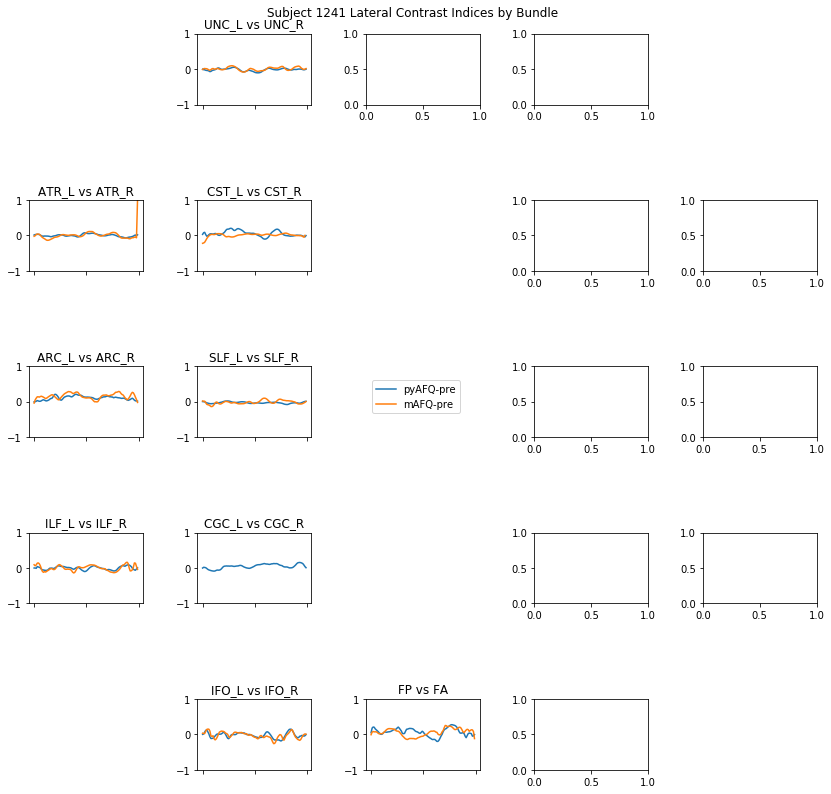

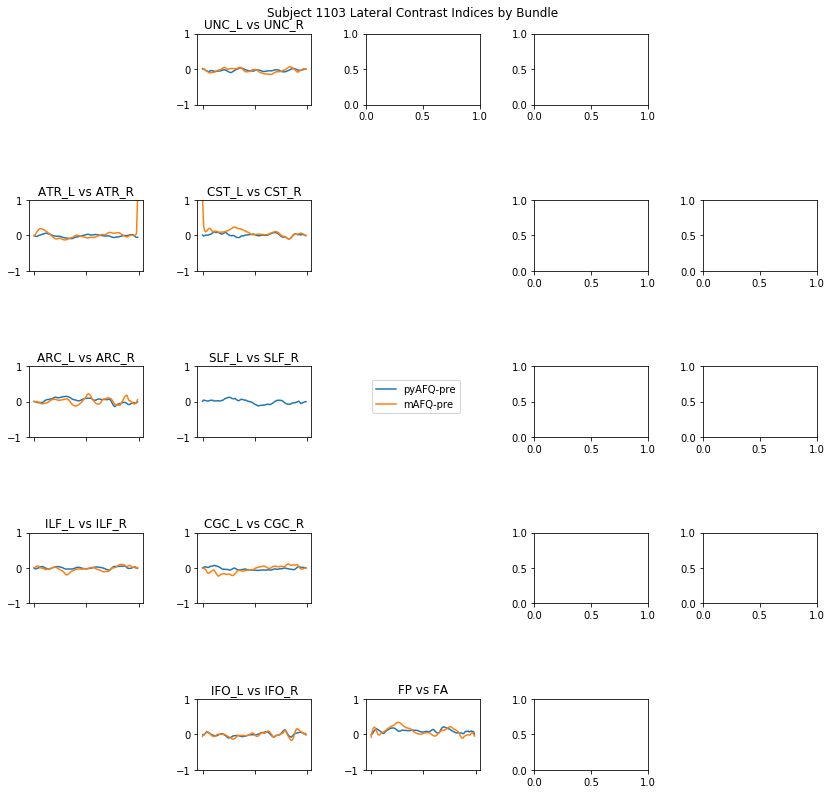

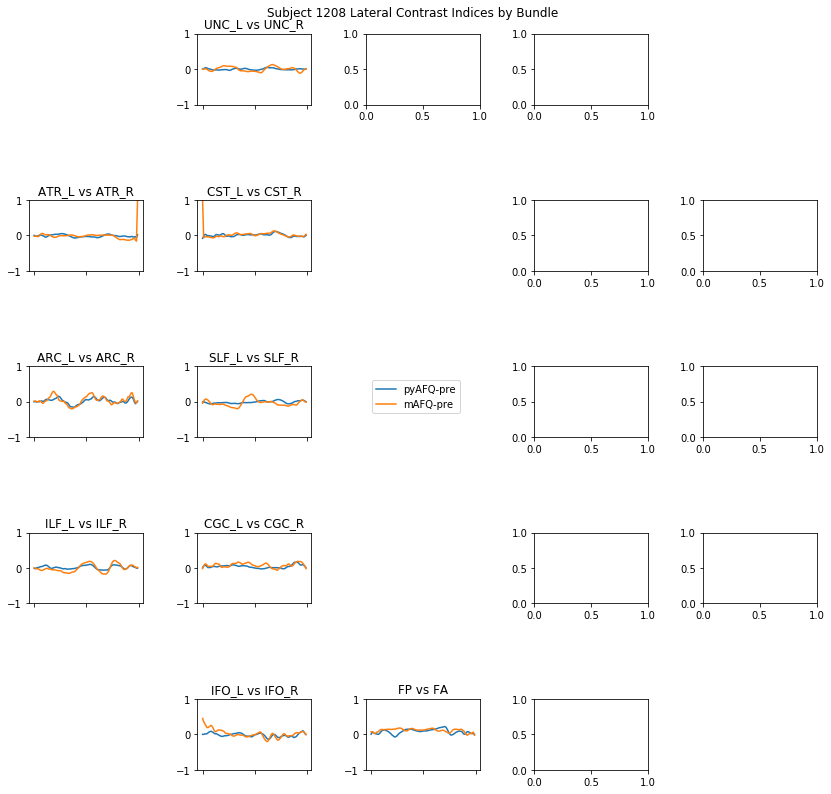

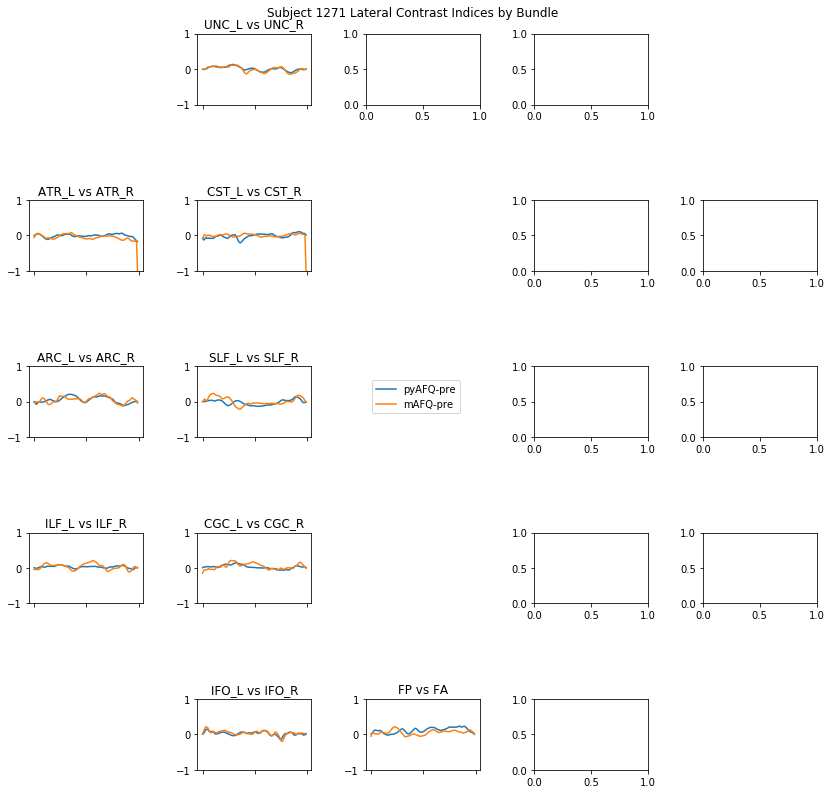

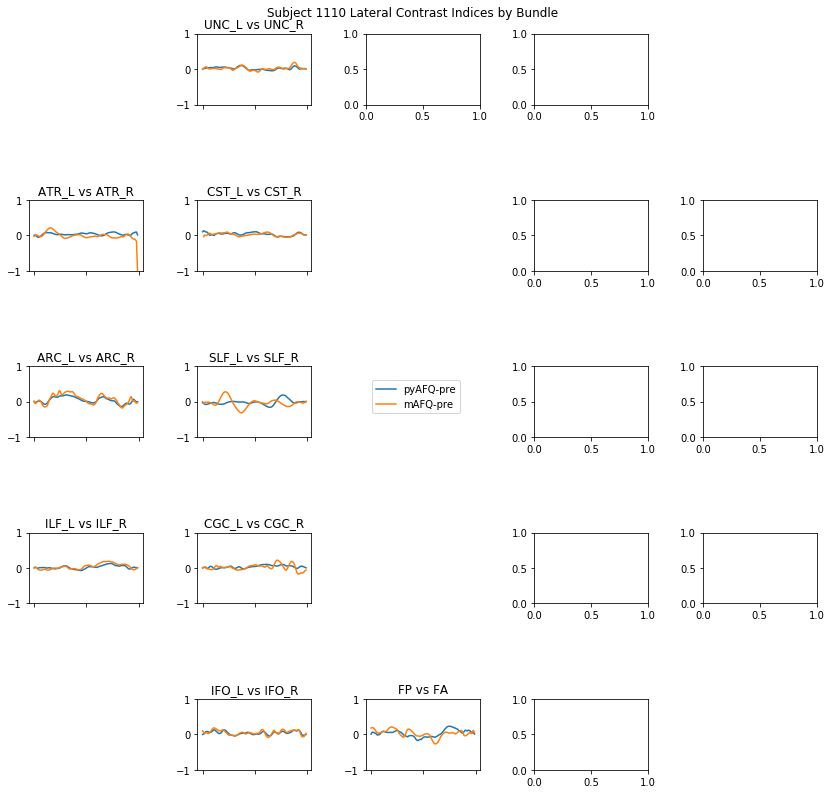

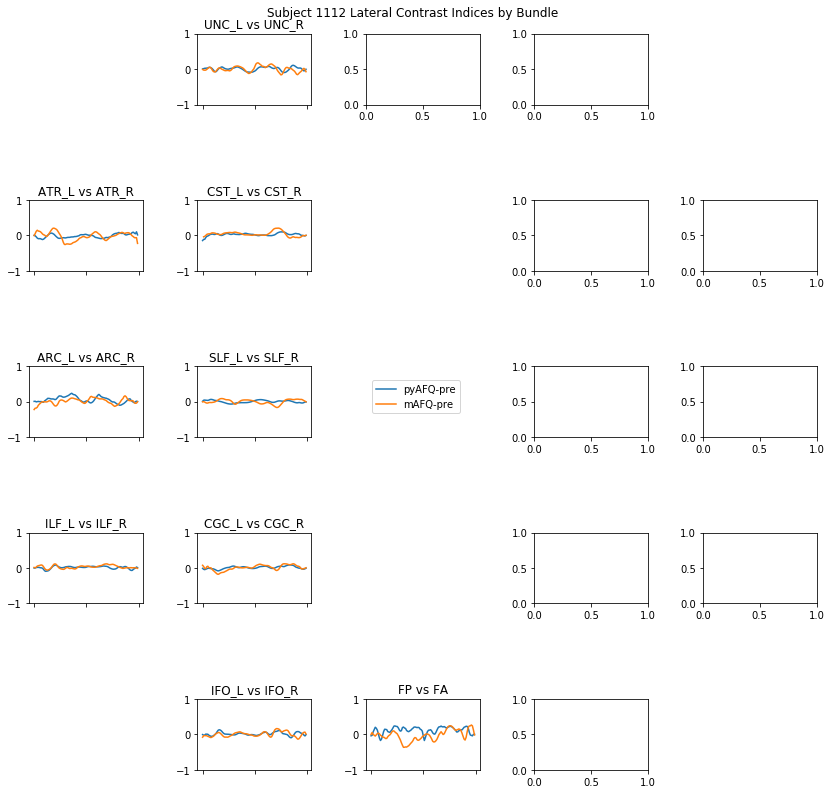

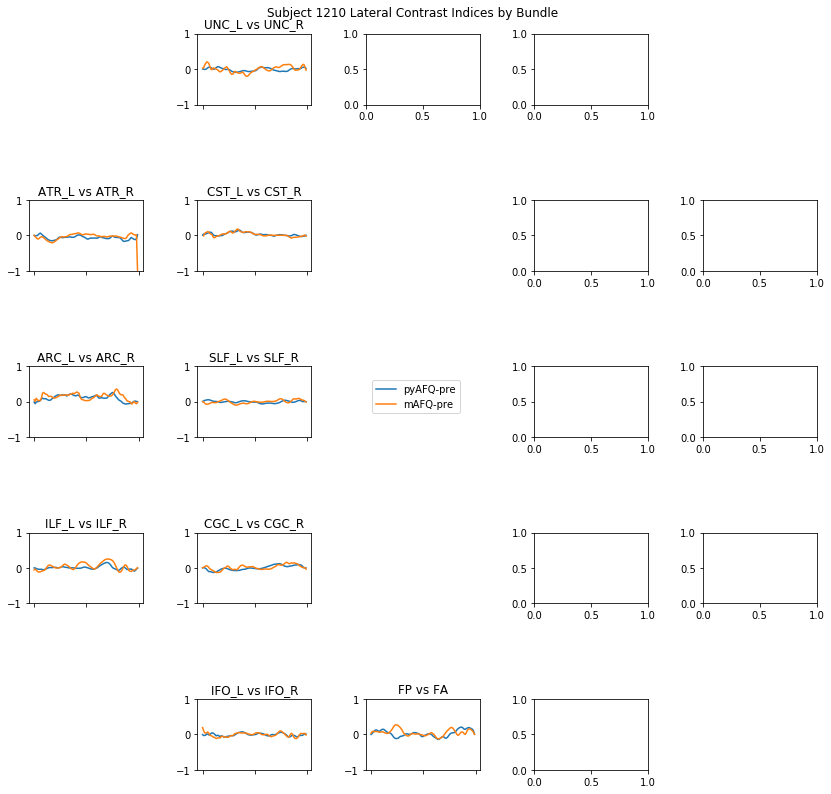

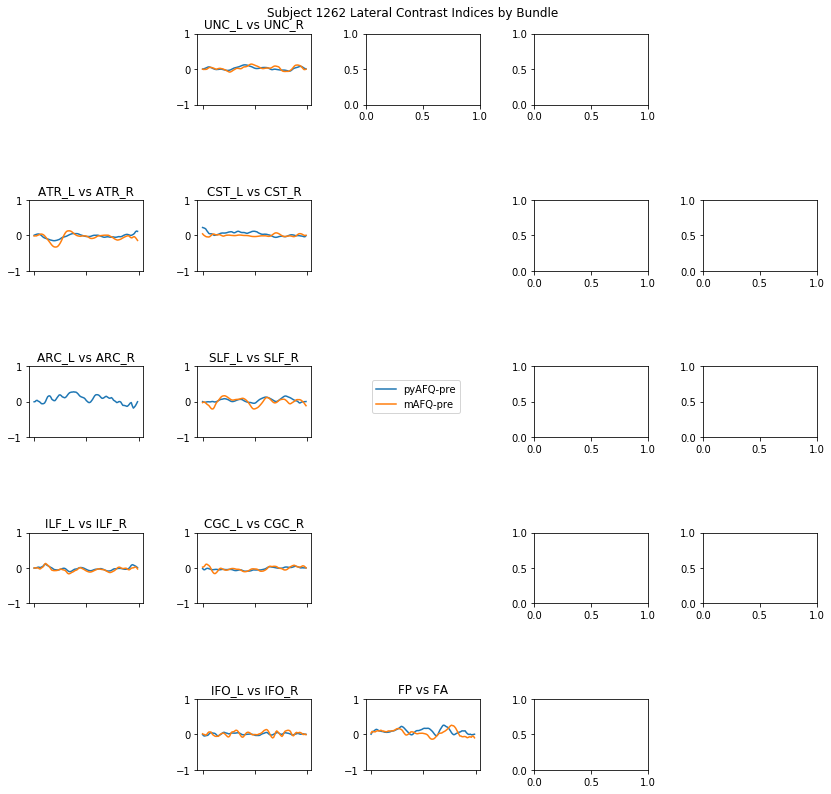

In [84]:
comparisons.lateral_contrast_index(names=['pyAFQ-pre', 'mAFQ-pre'], show_plots=True)